In [1]:
import pandas as pd
import numpy as np

# options data is only for 08/15/2019 because it is only a sample
data_options = pd.read_csv("sample_options_data\L3_options_20190815.csv", parse_dates = ["Expiration", " DataDate"])
data_optionstats = pd.read_csv("sample_options_data\L3_optionstats_20190815.csv")


In [2]:
# format dates into time until exp
data_options["TimeUntilExpiration"] = data_options.apply(lambda x: (x["Expiration"] - x[" DataDate"]).days, axis = 1)

# reformat call and put open interest into percentages of total interest
data_optionstats["calloipercent"] = data_optionstats["calloi"] / data_optionstats["totaloi"]
data_optionstats["putoipercent"] = data_optionstats["putoi"] / data_optionstats["totaloi"]

In [3]:
# merge dataframes to ensure that all data is of same length
data = data_options.merge(data_optionstats, left_on = "UnderlyingSymbol", right_on = "symbol")

# drop null and zero values
data.dropna(inplace = True)
data = data[data["Ask"] != 0]
data.head()

,UnderlyingSymbol,UnderlyingPrice,Flags,OptionSymbol,Type,Expiration,DataDate,Strike,Last,Bid,...,iv360put,iv360mean,callvol,putvol,totalvol,calloi,putoi,totaloi,calloipercent,putoipercent
0,A,69.59,*,A190816C00042500,call,2019-08-16,2019-08-15,42.5,0.0,25.05,...,0.2948,0.275,3976,3915,7891,25738,25259,50997,0.504696,0.495304
1,A,69.59,*,A190816P00042500,put,2019-08-16,2019-08-15,42.5,0.0,0.00,...,0.2948,0.275,3976,3915,7891,25738,25259,50997,0.504696,0.495304
2,A,69.59,*,A190816C00045000,call,2019-08-16,2019-08-15,45.0,0.0,22.35,...,0.2948,0.275,3976,3915,7891,25738,25259,50997,0.504696,0.495304
3,A,69.59,*,A190816P00045000,put,2019-08-16,2019-08-15,45.0,0.0,0.00,...,0.2948,0.275,3976,3915,7891,25738,25259,50997,0.504696,0.495304
4,A,69.59,*,A190816C00047500,call,2019-08-16,2019-08-15,47.5,0.0,19.85,...,0.2948,0.275,3976,3915,7891,25738,25259,50997,0.504696,0.495304


In [4]:
# each dataframe will be processed separately
greeks = pd.DataFrame(data = data[["UnderlyingSymbol", "Type", "TimeUntilExpiration", "Strike", "Delta", "Gamma", "Theta", "Vega"]])
market_state = pd.DataFrame(data = data[["symbol", "iv30call", "iv30put", "calloipercent", "putoipercent"]])
derivative = pd.DataFrame(data = data[["UnderlyingSymbol", "UnderlyingPrice", "Type", "TimeUntilExpiration", "Strike", "IVMean"]])
prices = pd.DataFrame(data = (data["Bid"] + data["Ask"] / 2), columns = ["Bid-Ask Avg"])

print(f"Greeks: {len(greeks)} rows \nMarket State: {len(market_state)} rows \nDerivative: {len(derivative)} rows \nPrices: {len(prices)} rows")


Greeks: 919647 rows 
Market State: 919647 rows 
Derivative: 919647 rows 
Prices: 919647 rows


In [5]:
from sklearn.preprocessing import LabelEncoder

def Format(df, quant_cols, qual_cols):
  formatted = pd.DataFrame()
  for col in quant_cols:
    formatted[col] = df[col]
  for col in qual_cols:
    encoder = LabelEncoder()
    encoder = encoder.fit(df[col].values)
    formatted[col] = encoder.transform(df[col].values)
  return formatted.values


In [6]:
from sklearn.model_selection import train_test_split

# greeks and iv are already standardized. calloi% and putoi% are already scaled as fractions of totaloi
g_cols = {"Quant": ["TimeUntilExpiration", "Strike", "Delta", "Gamma", "Theta", "Vega"], "Qual": ["Type"]}
m_cols = {"Quant": ["iv30call", "iv30put", "calloipercent", "putoipercent"], "Qual": []}
d_cols = {"Quant": ["UnderlyingPrice", "TimeUntilExpiration", "Strike", "IVMean"], "Qual": ["Type"]}
p_cols = {"Quant": ["Bid-Ask Avg"], "Qual": []}

# format data
g = Format(greeks, g_cols["Quant"], g_cols["Qual"])
m = Format(market_state, m_cols["Quant"], m_cols["Qual"])
d = Format(derivative, d_cols["Quant"], d_cols["Qual"])
p = Format(prices, p_cols["Quant"], p_cols["Qual"])

# split data into train and test
g_train, g_test, m_train, m_test, d_train, d_test, p_train, p_test = train_test_split(g, m, d, p, test_size = 0.1, random_state = 42)

In [ ]:
# config model 
import tensorflow as tf
from keras.layers import Dense, Input, concatenate
from keras.models import Model
from keras.optimizers import Adam

# greeks model
g_input = Input(shape = len(g_train[0]), name = "greeks_input")
g_d1 = Dense(256, name = "greeks_dense1")(g_input)
g_n = tf.keras.layers.BatchNormalization()(g_d1)
g_l = tf.keras.layers.LeakyReLU()(g_n)
g_d2 = Dense(256, activation = "gelu", name = "greeks_dense2")(g_l)

# market state model
m_input = Input(shape = len(m_train[0]), name = "market_input")
m_d1 = Dense(256, name = "market_dense1")(m_input)
m_n = tf.keras.layers.BatchNormalization()(m_d1)
m_l = tf.keras.layers.LeakyReLU()(m_n)
m_d2 = Dense(256, activation = "gelu", name = "market_dense2")(m_l)

# derivative input layer
d_input = Input(shape = len(d_train[0]), name = "derivative_input")

# output model
merge_data = concatenate([g_d2, m_d2, d_input], name = "merge")
output_n = tf.keras.layers.BatchNormalization()(merge_data)
output_l = tf.keras.layers.LeakyReLU()(output_n)
output_d1 = Dense(512, activation = "gelu", name = "output_dense1")(output_l)
output_d2 = Dense(512, activation = "gelu", name = "output_dense2")(output_d1)
output_n2 = tf.keras.layers.BatchNormalization()(output_d2)
output_d3 = Dense(1, activation = "relu", name = "output_dense3")(output_n2)

final_model = Model(inputs = [g_input, m_input, d_input], outputs = output_d3, name = "final_model")
final_model.summary()


In [9]:
# load model from file (if already trained)
import tensorflow as tf
final_model = tf.keras.models.load_model(r"path_to_folder")

In [338]:
# compile and train model
final_model.compile(loss = "mse", optimizer = Adam(learning_rate = .00001), metrics = ["accuracy"])
final_model.fit(x = [g_train, m_train, d_train], y = p_train, epochs = 15, batch_size = 5012, validation_split = .1, shuffle = True)

Epoch 1/15
149/149 [==============================] - 3s 16ms/step - loss: 15.0757 - accuracy: 1.7183e-04 - val_loss: 5.3960 - val_accuracy: 8.4573e-05
Epoch 2/15
149/149 [==============================] - 2s 14ms/step - loss: 14.4800 - accuracy: 1.7183e-04 - val_loss: 4.9849 - val_accuracy: 7.2491e-05
Epoch 3/15
149/149 [==============================] - 2s 14ms/step - loss: 14.6269 - accuracy: 1.4230e-04 - val_loss: 4.4404 - val_accuracy: 8.4573e-05
Epoch 4/15
149/149 [==============================] - 2s 15ms/step - loss: 14.3397 - accuracy: 1.7183e-04 - val_loss: 4.8656 - val_accuracy: 8.4573e-05
Epoch 5/15
149/149 [==============================] - 2s 15ms/step - loss: 15.3506 - accuracy: 1.8257e-04 - val_loss: 4.5915 - val_accuracy: 1.2082e-04
Epoch 6/15
149/149 [==============================] - 2s 14ms/step - loss: 14.2887 - accuracy: 1.7183e-04 - val_loss: 4.6058 - val_accuracy: 8.4573e-05
Epoch 7/15
149/149 [==============================] - 2s 14ms/step - loss: 15.0236 - acc

In [344]:
# save model into file
final_model.save("model")

INFO:tensorflow:Assets written to: model\assets


In [11]:
# predictions
preds = final_model.predict([g_test, m_test, d_test])
preds

2874/2874 [==============================] - 9s 2ms/step


array([[ 37.253227],
       [430.3918  ],
       [  6.517067],
       ...,
       [110.89511 ],
       [ 16.418604],
       [  0.      ]], dtype=float32)

In [12]:
# percent of predictions within 20% of actual price
within_20 = np.sum(np.abs((p_test - preds) / p_test) < .20) / len(p_test) * 100
within_20

51.48045452074159

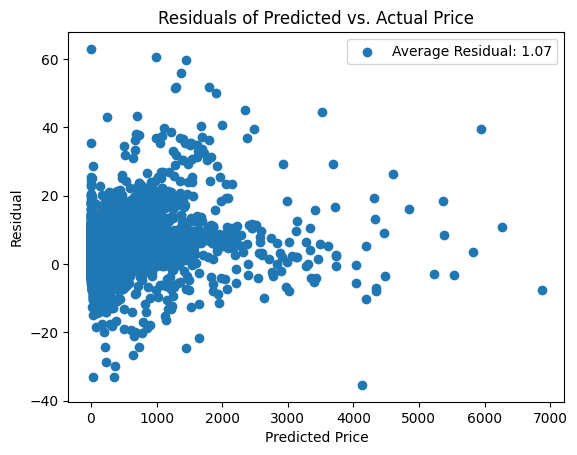

In [23]:
# graph residuals
import matplotlib.pyplot as plt
residuals = p_test - preds
plt.scatter(preds, residuals)
plt.xlabel("Predicted Price")
plt.ylabel("Residual")
plt.title("Residuals of Predicted vs. Actual Price")
plt.legend([f"Average Residual: {abs(residuals).mean():.2f}"])


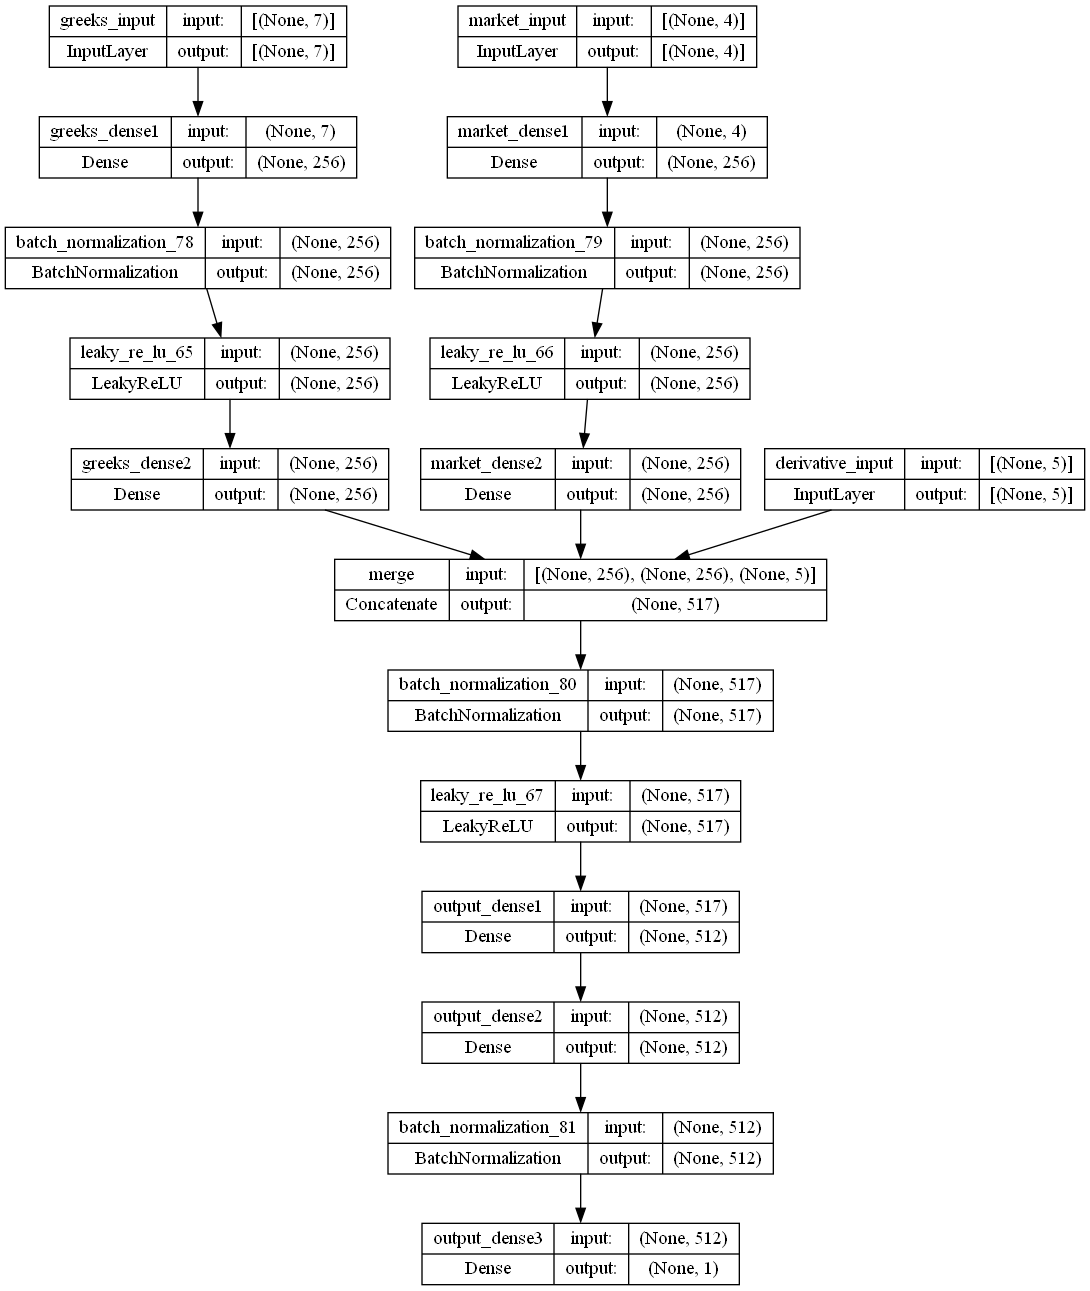

In [341]:
# plot model
import keras
keras.utils.plot_model(final_model, to_file = "model.png", show_shapes = True, show_layer_names = True)